# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
!pip install uninstall scipy
!pip install scipy==1.1.0
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir("drive/My Drive/cs231n/assignment1")

ERROR: Could not find a version that satisfies the requirement uninstall (from versions: none)
ERROR: No matching distribution found for uninstall
     |████████████████████████████████| 30.8MB 132kB/s 
ERROR: tensorflow 2.1.0 has requirement scipy==1.2.2; python_version < "3", but you'll have scipy 1.1.0 which is incompatible.
ERROR: tensorflow 2.1.0 has requirement tensorflow-estimator<2.2.0,>=2.1.0rc0, but you'll have tensorflow-estimator 1.15.0 which is incompatible.
ERROR: fastai 0.7.0 has requirement torch<0.4, but you'll have torch 1.4.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.2.2
    Uninstalling scipy-1.2.2:
      Successfully uninstalled scipy-1.2.2
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%

In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [4]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.318163
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [5]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.376574 analytic: 1.376574, relative error: 7.703188e-09
numerical: -2.525189 analytic: -2.525189, relative error: 7.870254e-09
numerical: 1.525434 analytic: 1.525434, relative error: 1.217336e-08
numerical: -0.533237 analytic: -0.533237, relative error: 1.629680e-07
numerical: -1.375309 analytic: -1.375309, relative error: 1.633066e-08
numerical: 0.050308 analytic: 0.050308, relative error: 6.910558e-07
numerical: 2.138223 analytic: 2.138223, relative error: 2.570925e-08
numerical: 2.295633 analytic: 2.295633, relative error: 2.938295e-08
numerical: -3.579048 analytic: -3.579048, relative error: 1.419860e-08
numerical: 1.292838 analytic: 1.292838, relative error: 3.100490e-08
numerical: 2.231784 analytic: 2.231783, relative error: 3.279955e-08
numerical: 1.505376 analytic: 1.505375, relative error: 2.599033e-08
numerical: -0.960357 analytic: -0.960357, relative error: 2.586619e-08
numerical: -0.349204 analytic: -0.349204, relative error: 8.141476e-08
numerical: 2.090614 an

In [7]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.318163e+00 computed in 0.118285s
vectorized loss: 2.318163e+00 computed in 0.016906s
Loss difference: 0.000000
Gradient difference: 0.000000


In [12]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-6, 3e-6, 5e-6, 1e-7, 2e-7, 3e-7, 4e-7, 5e-7, 5e-8, 7e-8, 9e-8]
regularization_strengths = [3e3, 5e3, 7e3, 9e3, 2.5e4, 3e4, 4e4, 5e4, 7e4, 9e4, 2e5, 4e5]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for i in range(len(learning_rates)):
  for j in range(len(regularization_strengths)):
    hyperpara = (learning_rates[i], regularization_strengths[j])
    softmax = Softmax()
    softmax.train(X_train, y_train, learning_rates[i], regularization_strengths[j], num_iters=1500, verbose=False)
    y_train_pred = softmax.predict(X_train)
    train_rate = np.mean(y_train == y_train_pred)
    y_val_pred = softmax.predict(X_val)
    validation_rate = np.mean(y_val == y_val_pred)
    if (best_val < validation_rate):
      best_val = validation_rate
      best_softmax = softmax
    results[(learning_rates[i], regularization_strengths[j])] = (train_rate, validation_rate)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

cs231n/classifiers/softmax.py:73: RuntimeWarning: overflow encountered in exp
  tmp_exp_score = np.exp(tmp_score)
cs231n/classifiers/softmax.py:79: RuntimeWarning: invalid value encountered in divide
  dW += (X.T).dot(tmp_exp_score / sum_tmp_score[:, None])


lr 5.000000e-08 reg 3.000000e+03 train accuracy: 0.244143 val accuracy: 0.238000
lr 5.000000e-08 reg 5.000000e+03 train accuracy: 0.254571 val accuracy: 0.243000
lr 5.000000e-08 reg 7.000000e+03 train accuracy: 0.272510 val accuracy: 0.284000
lr 5.000000e-08 reg 9.000000e+03 train accuracy: 0.288449 val accuracy: 0.286000
lr 5.000000e-08 reg 2.500000e+04 train accuracy: 0.329592 val accuracy: 0.338000
lr 5.000000e-08 reg 3.000000e+04 train accuracy: 0.322184 val accuracy: 0.331000
lr 5.000000e-08 reg 4.000000e+04 train accuracy: 0.316408 val accuracy: 0.331000
lr 5.000000e-08 reg 5.000000e+04 train accuracy: 0.309408 val accuracy: 0.330000
lr 5.000000e-08 reg 7.000000e+04 train accuracy: 0.301347 val accuracy: 0.310000
lr 5.000000e-08 reg 9.000000e+04 train accuracy: 0.291347 val accuracy: 0.306000
lr 5.000000e-08 reg 2.000000e+05 train accuracy: 0.278612 val accuracy: 0.283000
lr 5.000000e-08 reg 4.000000e+05 train accuracy: 0.256857 val accuracy: 0.270000
lr 7.000000e-08 reg 3.000000

In [13]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.384000


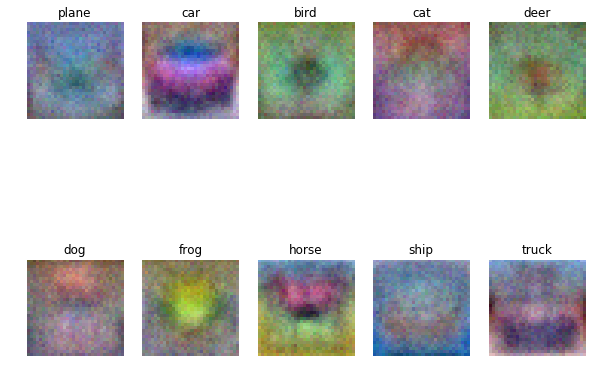

In [14]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])